### [주제]
#### 지방소멸의 요인 중 하나로 '일자리'가 지목된다. 지역에 따른 일자리의 수 - 즉, 양적 차이는 분명해 보인다. 그렇다면 지역에 따른 질적인 차이도 존재하는가? 또한, 그러한 차이가 지방소멸에 일정 수준 이상 기여하는가?

각종 구인 공고 사이트 중 하나인 인크루트에서 신입/인턴 구인 공고에서 '서울' 검색 시 약 7,000건, '경기'는 약 6,000건, '부산', '광주' 등 지방 광역시는 500~900건 정도의 공고가 검색된다. 지역에 따른 일자리의 양적 차이는 쉽게 알 수 있었고, 구체적으로 해당 사실을 검증하는 것을 목표로 하지는 않을 것이다. 대신 구인 공고에서 제시하는 일자리의 질적인 평가 또한 지역에 따라 갈릴 것인지, 쉽게 말해 수도권일수록 소위 괜찮은 직업/직장이 많고 지방권일수록 괜찮은 직업/직장이 적을 것인가? 에 대해 세 가지 가설을 통해 답을 구하고자 한다.



1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도학습).
지역에 따라 일자리의 질적인 수준이 명확하게 나뉠수록, 구인 공고 데이터를 모아서 지역을 예측할 때 정확도가 높은 모델을 만들기 쉬울 것이다.


2. 구인 공고 데이터 피쳐를 바탕으로 클러스터링 시에 크게 그룹 {우수한 일자리 / 중간 / 상대적으로 별로인 일자리} 로  나눌  수 있을 것이며, 우수한 일자리 그룹일수록 수도권에 해당하는 데이터포인트가 다수 분포할 것이다. (비지도 학습)

크게 세 그룹으로 나눌 수 있을 것으로 생각한 이유는 기업이 크게 대기업/중견/중소 세 그룹으로 분류가 가능하므로 구인 공고도 대기업의 공고 / 중견 / 중소기업 공고로 나뉠 것이라 기대했기 때문이다.


3. 질적인 차이가 클수록 지방소멸률도 크게 나타날 것이다.

1번과 2번 과정을 통해 지역마다의 일자리에 대한 질적인 차이 수준을 일정한 지표로 수치화하고, 그 지표와 지방소멸률 사이의 상관계수를 분석한다.


In [2]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)

## 데이터 피쳐 설명

### 지역 region, 학력 education, 고용 형태(인턴, 정규직, 계약직 등) jobtype

###	회사형태(대기업, 중소기업 등) cptype, 연 매출 sales, 직원 수 employees

### 평균연봉 aversalary, 자본금	capital

### 입사 지원하면 좋은 이유'들'을 점수로 종합 (ex. 연 매출 1,000위 이내, 자기 계발비 지원 등) pros_encoded

pros_encoded는 인크루트에서 데이터를 크롤링할 때 있었던, '입사 지원하면 좋은 이유' 항목들에 주관적으로 점수를 매긴 값이다.
이에 대한 자료는 'tags.csv', 'tags_encoded.csv' (어떻게 점수를 할당했는지) 가 있다.

'매출 1000대 기업', '대기업', 'KOSPI 상장' 등 객관적인 평가지표가 반영된 항목이면서 기업역량이 우수함을 쉽게 판단할 수 있는 항목에 주로 5점,
'육아휴직 제공', '자기 계발비 지원' 등 해당 항목이 부여된 기준을 알기 어렵고, 사실을 검증하기 어려운 항목들에 대해서는 1점을 주는 식으로 평가하였다.

In [ ]:
print(df.dtypes)
df.describe()

region            int64
education         int64
jobtype           int64
cptype            int64
sales           float64
employees       float64
aversalary      float64
capital         float64
pros_encoded    float64
dtype: object


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
count,3015.000000,3015.000000,3015.000000,3015.000000,2253.000000,2482.000000,2149.000000,2303.000000,3015.000000
mean,0.764842,0.836153,0.482587,0.670315,1.609243,0.972960,0.154087,1.615437,0.153018
std,0.808932,1.170736,0.499780,0.817098,3.502903,2.423187,0.750271,3.639170,0.609906
min,0.000000,0.000000,0.000000,0.000000,-0.130200,-0.209200,-1.782600,-0.113000,-0.500000
25%,0.000000,0.000000,0.000000,0.000000,-0.125200,-0.187600,-0.304300,-0.106550,-0.350000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,1.000000,1.000000,0.874800,0.812475,0.695700,0.893500,0.650000
max,2.000000,5.000000,1.000000,2.000000,11.933775,11.169989,2.391300,13.774974,2.800000


In [ ]:
print("2 -> 수도권 : 서울, 인천, 세종, 경기")
print("1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산")
print("0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주")
region_counts = df['region'].value_counts()

total = df['region'].value_counts().sum()
for region, counts in enumerate(region_counts):
    print(f"{region} -> {counts} ({np.round(counts/total, 4)})")

2 -> 수도권 : 서울, 인천, 세종, 경기
1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
0 -> 1424 (0.4723)
1 -> 876 (0.2905)
2 -> 715 (0.2371)


### 상관계수 및 VIF 확인 & 가중치 감쇠를 통한 Selected feature 존재 여부 확인 (불균형 데이터셋)

<h5> Sales 값이 VIF 도 가장 크고, Sales-Employees, Sales-capital 사이 (+) 상관관계도 유의미하다고 도출 </h5>

Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')
[ 0.0138997  -0.22190988 -0.09192981  0.01715186 -0.08623191 -0.04023043
 -0.0262521  -0.03452185]
[ 0.08998372  0.01819074 -0.27761532  0.08079271  0.00482503 -0.05119167
 -0.05360669 -0.45693555]
[-0.10388341  0.20371914  0.36954513 -0.09794456  0.08140688  0.0914221
  0.07985879  0.49145739]
Mean accuracy (train set) :  0.5163
Mean accuracy (test set) :  0.4441


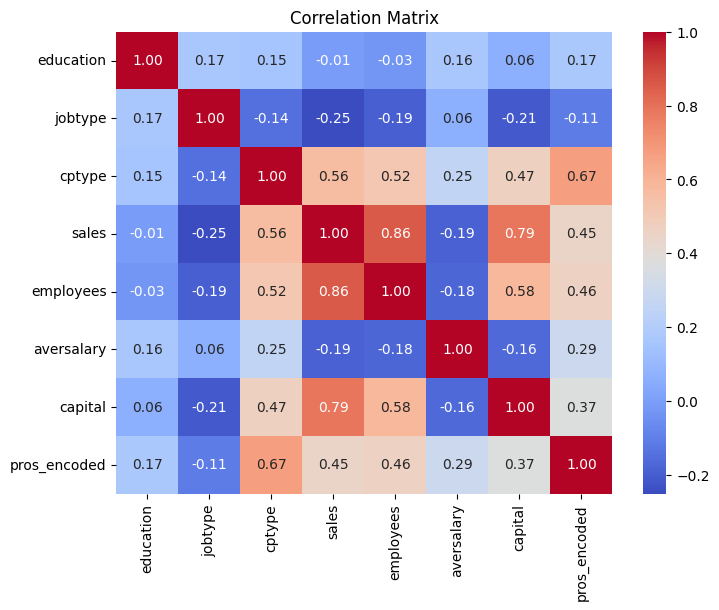

1.7006
1.619
3.3291
5.1123
4.4591
1.6113
2.7468
2.3063


In [ ]:
# NaN 처리
df_dropna = df.dropna()
X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747, stratify=y)

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

# feature selection -> sales, employees, capital
print(df.columns)
for coef_set in linear.coef_:
    print(coef_set)

print("Mean accuracy (train set) : ", np.round(linear.score(X_train, y_train), 4))
print("Mean accuracy (test set) : ", np.round(linear.score(X_test, y_test), 4))

correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### Undersampling 을 적용하여 동일한 과정 반복  
=> 일반화 성능은 올라갔고, test score 는 거의 변동없음  
=> 그 외 VIF, 상관계수도 거의 변동없음

Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')
[ 0.00917424 -0.14883198  0.01240081 -0.02021743 -0.05576485 -0.0289272
 -0.02285772  0.08172913]
[ 0.09282028 -0.06307684 -0.37626994  0.10402426 -0.01330218 -0.04235367
 -0.03913665 -0.48721088]
[-0.10199452  0.21190883  0.36386913 -0.08380683  0.06906703  0.07128086
  0.06199437  0.40548175]
Mean accuracy (train set) :  0.5031
Mean accuracy (test set) :  0.4208


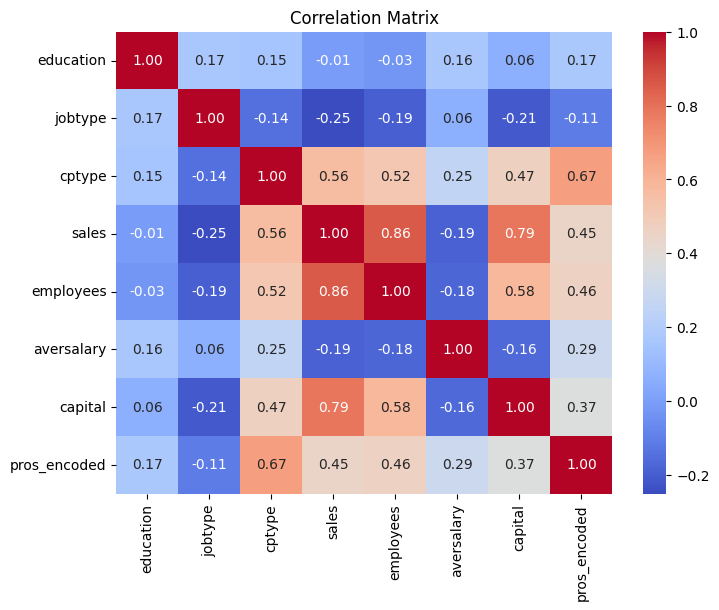

1.6554
1.6429
3.2992
5.6716
4.6758
1.5808
3.1238
2.4423


In [ ]:
# NaN 처리
df_dropna = df.dropna()

class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

df_dalanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_dalanced.reset_index(drop=True, inplace=True)

X = df_dalanced.iloc[:, 1:]
y = df_dalanced['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747, stratify=y)

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

# feature selection -> sales, employees, capital
print(df.columns)
for coef_set in linear.coef_:
    print(coef_set)

print("Mean accuracy (train set) : ", np.round(linear.score(X_train, y_train), 4))
print("Mean accuracy (test set) : ", np.round(linear.score(X_test, y_test), 4))

correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### GradientBoostingClassifier (불균형 데이터셋)

In [ ]:
df_dropna = df.dropna()

print(df_dropna['region'].value_counts())

X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

clf = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=0.2,
                                 max_depth=1,
                                 random_state=505).fit(X_train, y_train)
print(np.round(clf.score(X_test, y_test), 4))

region
0    780
1    440
2    432
Name: count, dtype: int64
0.4773


### GradientBoostingClassifier (UnderSampling 적용)

In [ ]:
df_dropna = df.dropna()
# 클래스 별로 400개씩 무작위로 샘플링
class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

df_dalanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_dalanced.reset_index(drop=True, inplace=True)

X = df_dalanced.iloc[:, 1:]
y = df_dalanced['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

clf = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=0.2,
                                 max_depth=1,
                                 random_state=505).fit(X_train, y_train)

print(np.round(clf.score(X_test, y_test), 4))

0.4708


### 중소기업일수록 회사정보가 등록되지 않았을 것(= 결측치로 수집되었을 것)이라고 가정
지금까지 결측치는 전부 drop 처리하고 진행하였다.

 => 가정이 참이라면 결측치를 drop 했을 경우 중소기업에 대한 행 데이터가 다수 빠졌을 것  
 => 양질(?)의 구인 공고 지역별 분포 현황을 분석하면서 '기업타입(대기업, 중견, 중소, ...)' 는 중요한 정보  
 => 최종 결론은 가정이 참일 경우 "결측치를 drop 하면 예측과 분석에 불리해진다." 가 된다.  

따라서 앞으로의 과정에는 결측값에 대한 별도 처리가 필요하지 않은 모델인 XgboostClassifier 를 사용해서 결측값을 포함해서 학습시켜 보고,
예측 성능이 더 좋다고 판단되면 해당 모델을 사용할 것이다. 앞으로의 과정을 요약하면 다음과 같다.

<ul>1. 결측값이 존재하는 행에 대해 데이터 탐색 과정을 거치고</ul>
<ul>2. 결측값을 포함하여 학습이 가능한 Xgboost 를 통해 결측값을 포함하여 학습 및 예측을 수행</ul>
<ul>3. 결측값을 제외한 채로 Xgboost 를 통해 학습 및 예측 수행</ul>
<ul>4. 1~3 과정을 통해 최선의 데이터셋 (baseline) 을 설정하고 하이퍼 파라미터 튜닝</ul>

In [ ]:
# df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)
nan_rows = df.isna().any(axis=1)
df_nan = pd.DataFrame(columns=df.columns)

for i in range(len(nan_rows)):
    if nan_rows[i]:
        row = df.iloc[i]  # NaN 값을 포함하는 행 선택
        df_nan = pd.concat([df_nan, pd.DataFrame([row], columns=df.columns)], ignore_index=True)


print(df_nan.describe())

df_nan.head()

            region    education      jobtype       cptype       sales  \
count  1363.000000  1363.000000  1363.000000  1363.000000  601.000000   
mean      0.735143     0.781365     0.463683     0.462949    3.064883   
std       0.781291     1.153061     0.498862     0.770643    4.729794   
min       0.000000     0.000000     0.000000     0.000000   -0.130200   
25%       0.000000     0.000000     0.000000     0.000000   -0.127200   
50%       1.000000     0.000000     0.000000     0.000000    0.000000   
75%       1.000000     1.000000     1.000000     1.000000    5.933400   
max       2.000000     5.000000     1.000000     2.000000   11.933775   

        employees  aversalary     capital  pros_encoded  
count  830.000000  497.000000  651.000000   1363.000000  
mean     0.878127   -0.180477    2.734666     -0.094828  
std      2.655539    0.626951    4.614355      0.536420  
min     -0.209200   -1.521700   -0.113000     -0.500000  
25%     -0.203600   -0.565200   -0.110700     -0.500

,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
0,2.0,0.0,0.0,0.0,11.933775,9.892039,0.8261,NaN,0.95
1,2.0,0.0,1.0,1.0,11.055401,10.369383,NaN,NaN,0.40
2,2.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,0.05
3,2.0,1.0,1.0,1.0,1.371700,0.885500,1.5652,NaN,0.60
4,2.0,0.0,1.0,2.0,0.312000,-0.027200,NaN,5.8862,1.00


<h5> 대부분의 결측값은 중소기업에 해당함을 확인 </h5>

In [ ]:
print("지역에 따른 결측값 분포: \n", df_nan['region'].value_counts())
print("회사 규모에 따른 결측값 분포: \n", df_nan['cptype'].value_counts())

지역에 따른 결측값 분포: 
 region
0.0    644
1.0    436
2.0    283
Name: count, dtype: int64
회사 규모에 따른 결측값 분포: 
 cptype
0.0    967
2.0    235
1.0    161
Name: count, dtype: int64


### Xgboost classifier


In [4]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Imbalanced Dataset :

VIF 와 상관계수 수치상, 'sales' 피쳐는 좋은 피쳐가 아니라고 판단된다.  
따라서 해당값은 제외하고 학습을 진행한 경우 / 그렇지 않은 경우를 비교  
=> 실행 할 때마다 두 경우의 비교우위관계는 달라졌다.  
=> 'sales' 값을 제외하지 않고 그냥 그대로 두고 학습 진행하기로 판단.

In [38]:
X = df.iloc[:, 1:]
y = df['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb = XGBClassifier(n_estimators=300, learning_rate = 0.1, max_depth=3)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy_score(y_test, y_pred)

0.5406301824212272

In [39]:
X = df.loc[:, ['education', 'jobtype', 'cptype', 'employees',
       'aversalary', 'capital', 'pros_encoded'],]
y = df['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb = XGBClassifier(n_estimators=300, learning_rate = 0.1, max_depth=3)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy_score(y_test, y_pred)

0.5505804311774462

### Imbalanced Dataset (drop na) : 결측값을 포함했을 때보다 score 소폭 감소

In [ ]:
X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

xgb = XGBClassifier(n_estimators=300, learning_rate = 0.1, max_depth=3)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy_score(y_test, y_pred)

0.5347432024169184

### Balanced dataset (undersampling)

In [ ]:
class_0_sample = df[df['region'] == 0].sample(n=400, replace=False)
class_1_sample = df[df['region'] == 1].sample(n=400, replace=False)
class_2_sample = df[df['region'] == 2].sample(n=400, replace=False)

df_dalanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_dalanced.reset_index(drop=True, inplace=True)

X = df_dalanced.iloc[:, 1:]
y = df_dalanced['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

xgb = XGBClassifier(n_estimators=300, learning_rate = 0.1, max_depth=3)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy_score(y_test, y_pred)

0.4666666666666667

### 하이퍼 파라미터 튜닝

앞선 과정들을 통해 베이스라인은 {'결측값은 그대로 둔다', 'Imbalanced dataset (데이터 분포 그대로 두기)', 'XGBoostClassifier'} 로 결정

In [ ]:
X = df.iloc[:, 1:]
y = df['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)


param_dist = {
    'n_estimators' : np.arange(100, 500, 50),
    'learning_rate' : np.arange(0, 1, 0.02),
    'max_depth' : np.arange(2, 5),
}

xgbClassifier = XGBClassifier()

randSearch = RandomizedSearchCV(xgbClassifier, param_distributions=param_dist, n_iter=100, random_state=4885, cv=3)

randSearch.fit(X_train, y_train)

print("Best Parameters: ", randSearch.best_params_)
print("Best Score: ", randSearch.best_score_)

Best Parameters:  {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.54}
Best Score:  0.5207296849087893


 예측 정확도는 무조건 class 0 (지방 지역) 로 예측하는 모델의 정확도 0.4723 보다 약간 더 높은 0.5207 (Cross validation 적용, CV 적용하지 않을 경우 0.5572)

자료 (https://stackoverflow.com/questions/53182709/how-to-calculate-accuracy-score-of-a-random-classifier) 에서의 공식에 따라 무작위 예측 모델의 정확도는 다음으로 계산되었다.    
random classifier accuracy = 0.4723^2 + 0.2905^2 + 0.2371^2 = 0.3637

### 튜닝된 모델에 대한 testdata 예측 및 예측결과 시각화

2 -> 수도권 : 서울, 인천, 세종, 경기
1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
0 -> 1424 (0.4723)
1 -> 876 (0.2905)
2 -> 715 (0.2371)


d:\anaconda3\envs\myvenv\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


acc:  0.5572139303482587
value_counts of y_test
 region
0    298
1    173
2    132
Name: count, dtype: int64
value_counts of y_pred
 [366 117 120]


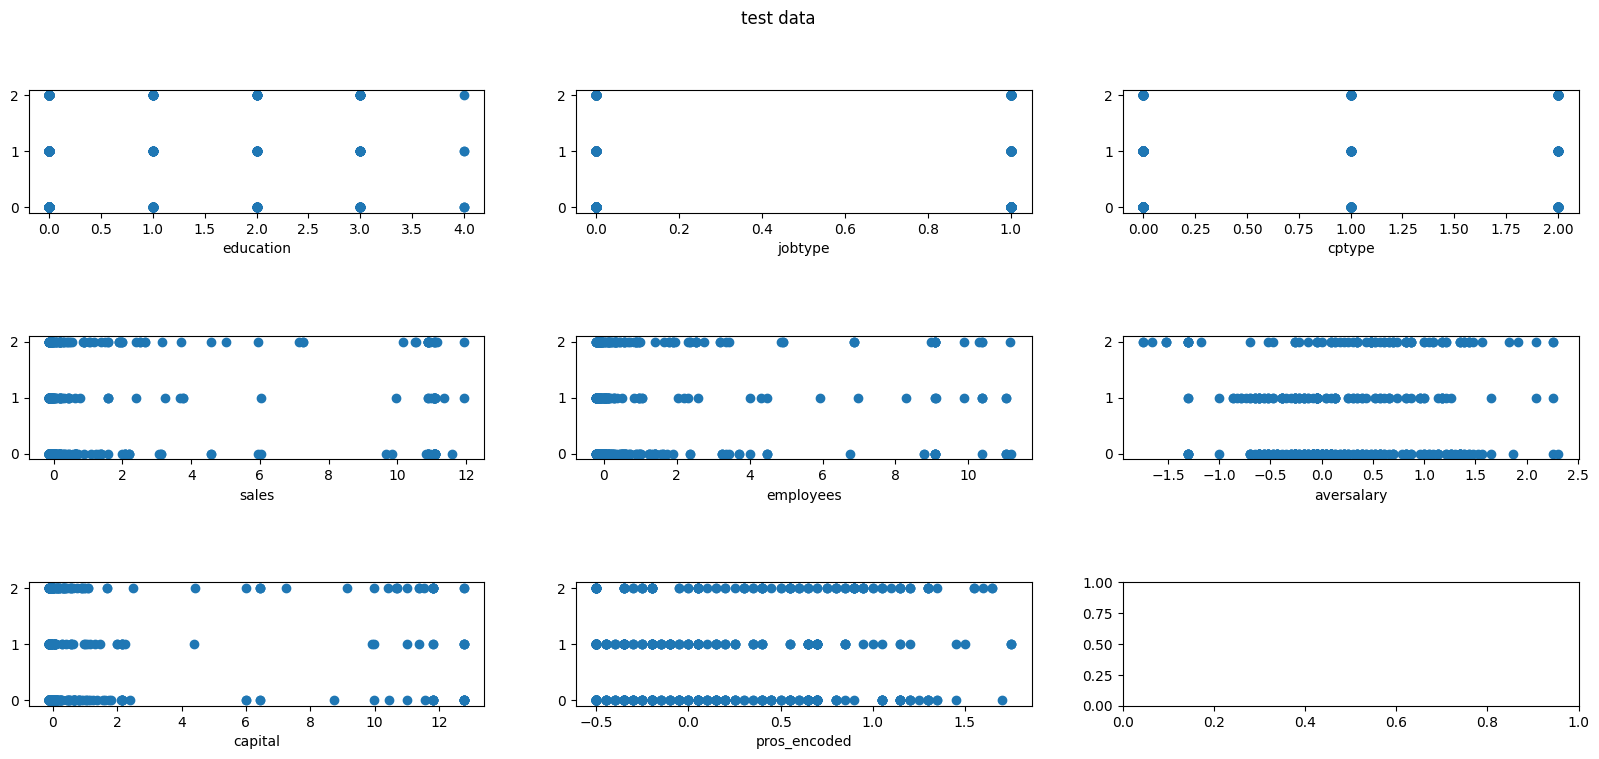

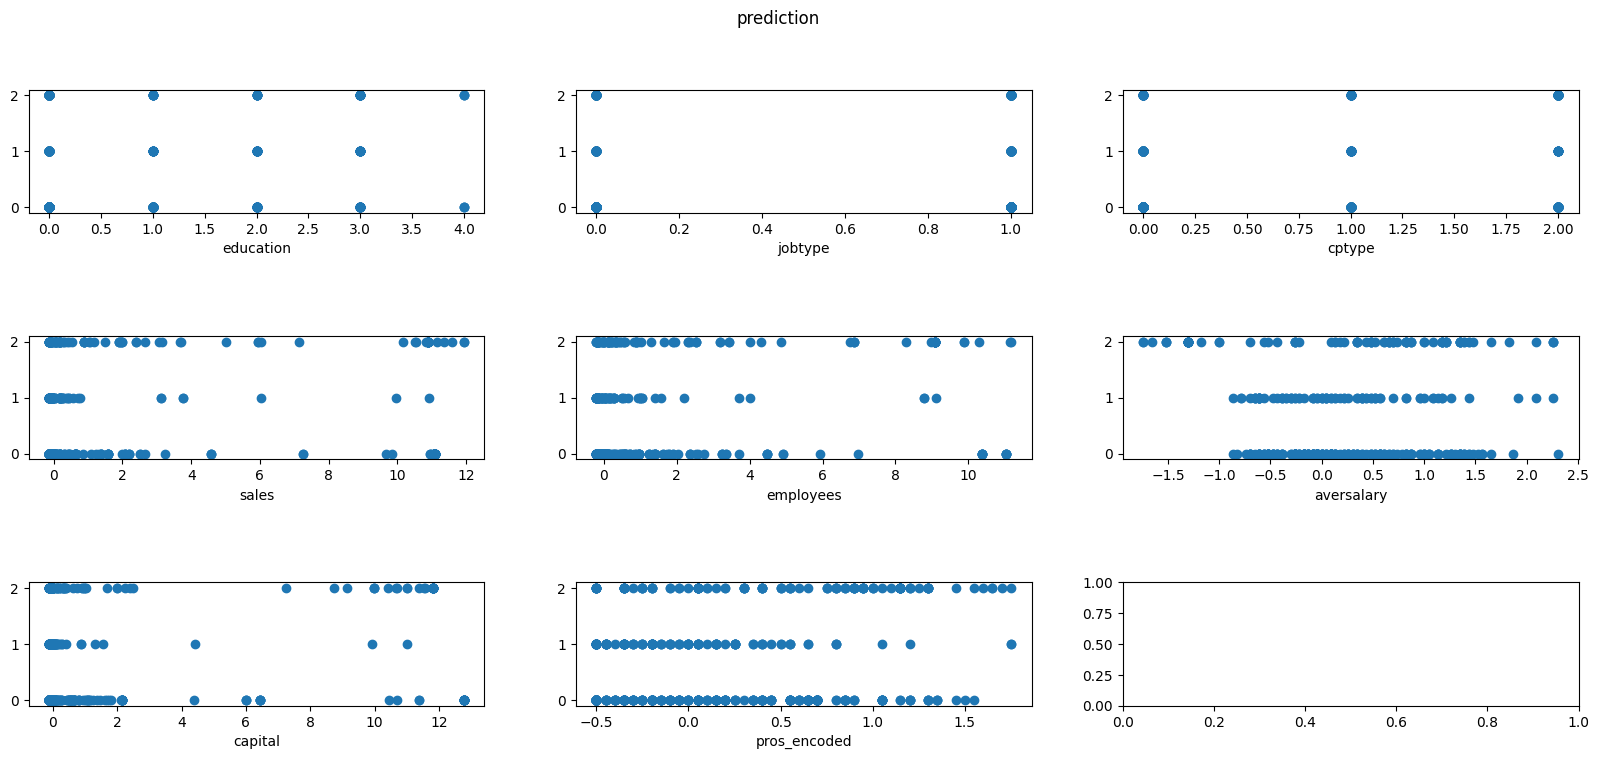

In [48]:
print("2 -> 수도권 : 서울, 인천, 세종, 경기")
print("1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산")
print("0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주")
region_counts = df['region'].value_counts()

total = df['region'].value_counts().sum()
for region, counts in enumerate(region_counts):
    print(f"{region} -> {counts} ({np.round(counts/total, 4)})")

X = df.iloc[:, 1:]
y = df['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)


# Best Parameters:  {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.54}

xgbClassifier_tuned = XGBClassifier({'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.54})

xgbClassifier_tuned.fit(X_train, y_train)
y_pred = xgbClassifier_tuned.predict(X_test)

print("acc: ", accuracy_score(y_test, y_pred))

print("value_counts of y_test\n", y_test.value_counts())
print("value_counts of y_pred\n", np.bincount(y_pred))

## X_test - y_test 산점도
features = df.columns[1:]

fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(20, 8))

fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_test)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])
plt.suptitle("test data")
plt.show()

## X_test - y_pred 산점도
fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(20, 8))
fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_pred)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])

plt.suptitle("prediction")
plt.show()

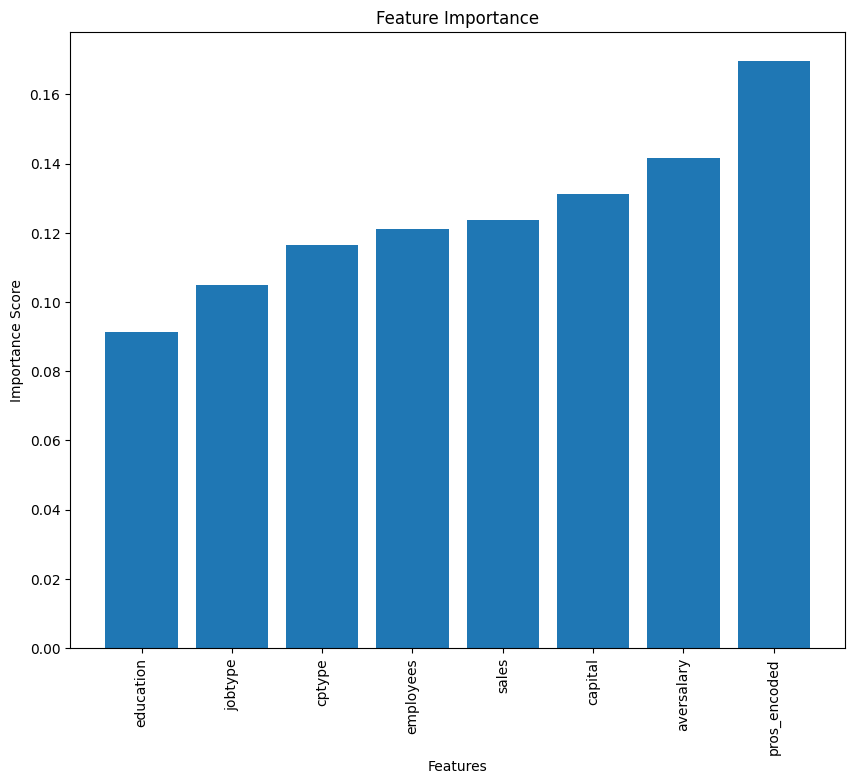

In [47]:
feature_importance = xgbClassifier_tuned.feature_importances_
# 오름차순 정렬 시 인덱스
sorted_idx = np.argsort(feature_importance)

X = df.iloc[:, 1:]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


수집한 약 3000여개 행 데이터를 가지고 지도학습모델(xgboost사용) 을 생성하여 '구인 공고 모집 지역'을 예측해 보았다.

생성한 모델로 예측한 결과, 무작위 예측 시 정확도 약 0.3637 에 비해 소폭 높은 테스트 정확도 약 0.5572 를 기록하였다.

따라서 그렇게 높은 정확도는 아니지만, 크롤링으로 수집한 데이터가 제한적이었던 점을 감안하고도 무작위 예측보다 약 20% 더 높은 정확도를 기록했음을 감안하여 설정한 가설 중 첫 번째인 < 1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도학습). > 는 어느 정도는 맞는 것으로 판단하고자 한다.

## 가설 검정

In [23]:
from scipy import stats

Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')
region
0    1424
1     876
2     715
Name: count, dtype: int64


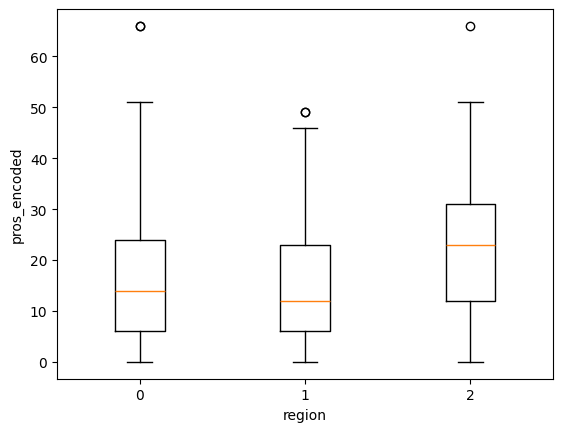

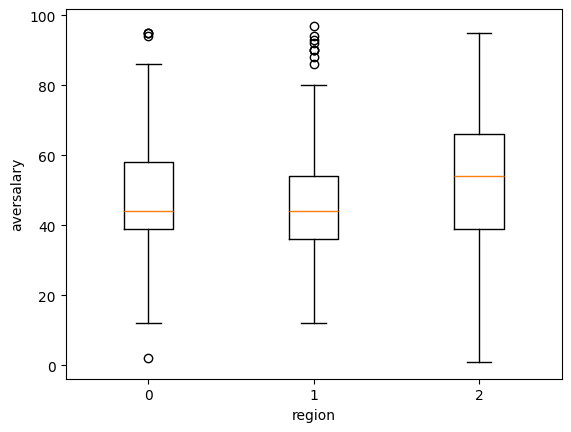

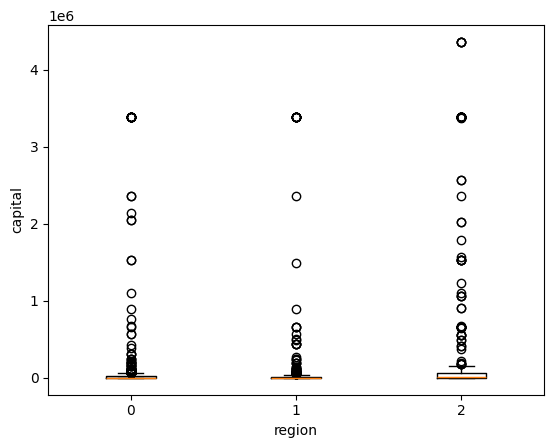

In [33]:
df = pd.read_csv('data_beforeScaling.csv', encoding='utf-8-sig', index_col=0)

df_dropna = df.dropna()

print(df.columns)
print(df['region'].value_counts())

region_0 = df_dropna[df_dropna['region'] == 0]
region_1 = df_dropna[df_dropna['region'] == 1]
region_2 = df_dropna[df_dropna['region'] == 2]

# 튜닝된 XgboostClassifier 에서 feature importance 상위 3개. Numeric
features = ['pros_encoded', 'aversalary', 'capital']

for feature in features:
    plot_data = [region_0[feature], region_1[feature], region_2[feature]]
    ax = plt.boxplot(plot_data, labels=[0, 1, 2])
    plt.xlabel("region")
    plt.ylabel(feature)
    plt.show()

### 검정 과정 및 결과 요약

튜닝된 XgboostClassifier 에서 feature importance 상위 3개 Numeric 피쳐 ['pros_encoded', 'aversalary', 'capital'] 에 대해 One-way ANOVA 검정 수행  
표본평균이 통계적으로 유의미한 수준으로 차이남을 확인  

정규성은 만족하지 않으나, bartlett's test 를 통해 등분산성 확인.

In [34]:
features = ['pros_encoded', 'aversalary', 'capital']

print("정규성 만족 확인")
# pvalue > 0.05 이상이면 정규성 만족
for feature in features:
    print(feature)
    print(stats.shapiro(region_0[feature]).pvalue)
    print(stats.shapiro(region_1[feature]).pvalue)
    print(stats.shapiro(region_2[feature]).pvalue)

# 정규성은 만족하지 않으나, 비모수 검정보다 모수 검정이 더 유효하다고 판단
# 중심 극한 정리에 의해 정규성을 따르지 않더라도 모수적 검정 가능하다는 글을 참고함.
# reference : https://blog.minitab.com/ko/adventures-in-statistics-2/choosing-between-a-nonparametric-test-and-a-parametric-test
# https://statisticsbyjim.com/hypothesis-testing/nonparametric-parametric-tests/

print("\n등분산성 확인 (bartlett's test)")
# 등분산성 확인
for feature in features:
    print(feature)
    # bartlett 검정에서 p-value 가 작다면 등분산성일 가능성이 낮다
    # ref. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett
    print(stats.bartlett(stats.shapiro(region_0[feature]), 
                       stats.shapiro(region_1[feature]), 
                       stats.shapiro(region_2[feature])).pvalue)

print("\none-way ANOVA")
for feature in features:
    print(stats.f_oneway(region_0[feature], region_1[feature], region_2[feature]))

정규성 만족 확인
pros_encoded
2.0417284676573435e-15
6.11914401374466e-14
4.077762406006191e-06
aversalary
4.327476979636317e-11
7.007666815514323e-07
8.01951850755442e-12
capital
4.7615466119399145e-49
3.844996469191931e-39
2.600756162531475e-34

등분산성 확인 (bartlett's test)
pros_encoded
0.9989575089562657
aversalary
0.9995357888129095
capital
0.7613775291558502

one-way ANOVA
F_onewayResult(statistic=54.41740370023299, pvalue=1.3002302415233098e-23)
F_onewayResult(statistic=5.923315229931658, pvalue=0.002733589619109128)
F_onewayResult(statistic=29.428691826038236, pvalue=2.767483257396838e-13)


<한계점 분석>  
수집한 데이터의 품질이 떨어져서 문제의 본질인 일자리의 '질적 평가'를 원하는 수준만큼 정확하게 내리지 못하였다.

구인 공고에서 가장 중요하다고 생각하는 연봉정보는 대부분 '회사 내규' 혹은 간혹 있더라도 이미지 내에 표시되어 있어 크롤랑하여 사용하지 못하였다. 회사 재정정보는 회사마다 최신화된 정보가 아닌 경우가 대부분이었으며, 이러한 이유로 인해 구인 공고 데이터를 통해 해당 일자리가 질적으로 우수한지 정확하게 평가하지 못하였다고 생각하고 가설도 검증에 실패할 것으로 예상하였다. 하지만 그럼에도 기대 이상의 분석 결과를 얻어 만족한다.